<a href="https://colab.research.google.com/github/adityamittal13/Semisupervised-GANs-for-Melanoma-Detection/blob/main/MNIST_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

if torch.cuda.is_available():
   print("Your Colab notebook is configured to run on the GPU!")
else:
   print("If you see this message, your Colab notebook is currently running on the CPU. Click the Runtime dropdown menu, select Change runtime type, and  choose GPU in the list of Hardware accelerators")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Your Colab notebook is configured to run on the GPU!


In [66]:
# !pip install python
# !pip install torchvision
# !pip install torchvision
# !pip install numpy
# !pip install sklearn
# !pip install matplotlib

In [67]:
# Hyperparameters 

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10 # Logarithm interval used for scaling hyperparameters up and down

random_seed = 1
torch.backends.cudnn.enabled = False # Algorithms that will produce a different output for the same input are called nondeterministic algorithms - disabled this here
torch.manual_seed(random_seed) # Made a random seed to be used later in the code

In [68]:
# Loading in the training dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(), # Converting dataset into a tensor for later use
                               torchvision.transforms.Normalize( # Normalizing the tensor with regards to the global mean and standard deviation for the MNIST dataset
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

# Loading in the testing dataset
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(), # Converting dataset to tensor for later use
                               torchvision.transforms.Normalize( # Normalizing the tensor with regards to the global mean and standard deviation for the MNIST dataset
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# Other features of DataLoader:
#   1. Can use num_workers > 1 to use subprocesses that will asynchronously load data
#   2. Can use pinned RAM (with pin_memory) to speed up RAM for GPU transfers

In [69]:
# Look at some examples
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data[0][0][0])
print(example_targets[:50])
print(batch_idx)

tensor([-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242, -0.4242])
tensor([4, 4, 2, 1, 8, 8, 2, 8, 3, 8, 5, 5, 5, 3, 0, 3, 6, 3, 0, 7, 0, 7, 2, 3,
        3, 4, 8, 2, 6, 1, 1, 2, 9, 5, 8, 2, 0, 3, 2, 3, 9, 9, 9, 3, 7, 9, 5, 7,
        2, 1])
0


In [70]:
example_data.shape

torch.Size([1000, 1, 28, 28])

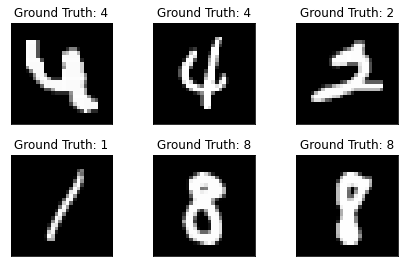

In [71]:
# Takes the first 6 target images and displays their image and observed result

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [72]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # Two-dimensional network with 5 kernels and input of 1 channel and output of 10 channels
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # Two-dimensional network with 5 kernels and input of 10 channels and output of 20 channels
        self.conv2_drop = nn.Dropout2d() # Use dropout to reduce overfitting
        self.fc1 = nn.Linear(320, 50) # Two linear models to reduce the neurons to an output of 10 (one for each number)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # Max pooling (add white border) over several input planes - take self.conv1(x) as number of rows and 2 as number of cols
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # Do same as first step here
        x = x.view(-1, 320) # Convert the tensor into a 2-D array of n rows and 320 columns
        # -1 used when don't know number of rows but do know number of columns
        x = F.relu(self.fc1(x)) # Run ReLU command on linearized model
        x = F.dropout(x, training=self.training) # Do another dropout (linear not 2D)
        x = self.fc2(x) # Last linear model
        return F.log_softmax(x) # Take softmax so outcome comes in form of probablility

In [73]:
# Initializing the network and the optimizer

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum) # network.parameters() provides what parameters the SGD has to optimize

In [74]:
# Used to create visualizations for model analysis later on
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [75]:
def train(epoch):
  network.train() # Tells the model that you are training the model, not testing it - so can use features like dropout and batch normalization
  for batch_idx, (data, target) in enumerate(train_loader): # batch_idx = index of batch currently on
    optimizer.zero_grad() # Manually set the gradients to zero since PyTorch accumulates gradients
    output = network(data) # Feedforward through the network
    loss = F.nll_loss(output, target) # Calculates negative log-likelihood loss
    loss.backward() # Backpropogation through the network
    optimizer.step() # Updates the weights on the network
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item())) # loss.item() - value of the loss
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset))) 
      torch.save(network.state_dict(), './results/model.pth') # Save network
      torch.save(optimizer.state_dict(), './results/optimizer.pth') # Same optimizer model - can use later by calling .load_state_dict(state_dict)

In [76]:
def test():
  network.eval() # Tells the model that you are testing the model
  test_loss = 0
  correct = 0
  with torch.no_grad(): # Avoid storing computations done storing output of network
    for data, target in test_loader:
      output = network(data) # Feedforward through network
      test_loss += F.nll_loss(output, target, size_average=False).item() # Adds the negative log-likelihood loss
      pred = output.data.max(1, keepdim=True)[1] # Makes prediction by taking max value from output layer
      correct += pred.eq(target.data.view_as(pred)).sum() # Checks how many of these were correct out of the entire batch size
  test_loss /= len(test_loader.dataset) # Divides loss across all of data points to see for each point
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [77]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368649
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298366
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.294433
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.260970
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.295450
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.239506
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.274136
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.225711
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.168033
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.138118
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.061368
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.945130
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.949193
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.750880
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.642634
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.585531
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.416778
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.314595
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.256788
Train Epoch: 1 [12160/6

Text(0, 0.5, 'negative log likelihood loss')

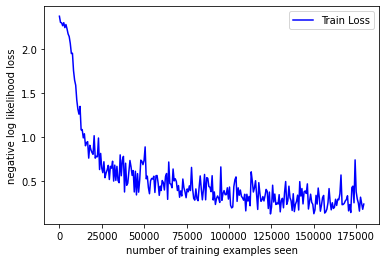

In [78]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
#plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Text(0, 0.5, 'negative log likelihood loss')

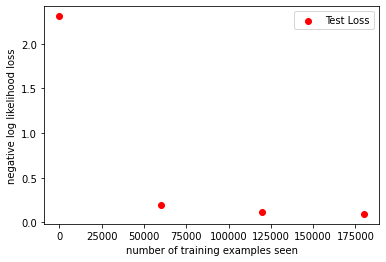

In [79]:
fig = plt.figure()
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [80]:
print(test_counter)

[0, 60000, 120000, 180000]


In [81]:
print(test_losses)

[2.308917626953125, 0.19328246459960938, 0.12118170700073243, 0.0958678855895996]


In [82]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


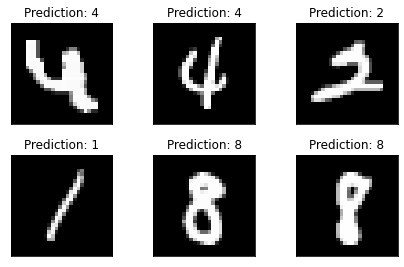

In [83]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.669169
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.193975
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.195679
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.307104
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.203755
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.238004
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.257517
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.335847
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.209687
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.280779
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.284504
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.287162
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.189130
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.319709
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.131248
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.271623
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.150488
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.381778
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.241011
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.357388
Train Epoch: 4 [12800/60000 (

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0840, Accuracy: 9731/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.145342
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.195255
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.433602
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.271662
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.121323
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.131053
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.223992
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.239263
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.335057
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.148383
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.209648
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.236725
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.277895
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.281379
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.271037
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.220026
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.342497
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.208678
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.245290
Train Epoch: 5 [12160

Text(0, 0.5, 'negative log likelihood loss')

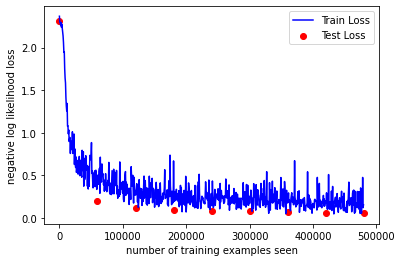

In [84]:
# Continued Training from Checkpoints

# Initialize New Network
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

# Load Old Model In
network_state_dict = torch.load('./results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('./results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

# Train and Test Model
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

# Prediction
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')